### Project Code
#### Part 1: Generating the coastal counties geospatial dataframe

Census.gov provides geospatial data for the contiguous US. This dataset is used as the starting point for this project. Given the focus on sea level rise, this base dataset is reduced to geospatial data for the contiguous US coastline (at the county level). 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
plt.style.use("fast")

In [2]:
def create_base_gs_df():
    """This is a support function used by the create_coastal_gs_df function to create a base geopandas DF for 
    the contiguous US"""
    
    gs_df_all = gpd.read_file("Data/Final_Data/cb_2022_us_tract_5m.zip") #master geospatial database

    #creating unique ids for counties and census tracts
    gs_df_all['county_code'] = gs_df_all.apply(lambda x: x.STATEFP + x.COUNTYFP, axis = 1)
    gs_df_all['census_tract_code'] = gs_df_all.apply(lambda x: x.STATEFP + x.COUNTYFP + x.TRACTCE, axis = 1)
    
    #dropping non contiguous territories -Alaska (02), Puerto Rico (72), Virgin Islands (78), Northern Mariana Islands(69), 
    #American Samoa (60), Guam (66) and Hawaii (15)
    gs_df_all = gs_df_all[~gs_df_all.STATEFP.isin(['02', '72', '78', '15', '60', '66', '69'])]

    #other cleanup
    gs_df_all.rename(columns = {"STATE_NAME":"state_name", "NAMELSADCO":"county_name"}, inplace = True)
    gs_df_all.drop(["STUSPS", "STATEFP", "COUNTYFP", "TRACTCE" ,"AFFGEOID", "NAME", "NAMELSAD", "LSAD", "ALAND", "AWATER", 
                    "GEOID"], axis = 1, inplace = True)
    gs_df_all["county_name"] = [name[:-7] if "County" in name else name for name in gs_df_all.county_name]
    
    return gs_df_all

def create_coastal_counties_df():
    """This is a support function used by the create_coastal_gs_df function create a simple dataframe of coastal counties 
    in the contiguous US"""
    
    ccounties = pd.read_csv("Data/Final_Data/coastline-counties-list.csv", usecols=[0,3,4], skiprows=2, nrows = 255, 
                            dtype = str)
    ccounties.columns = ["county_code", "county_name", "state_name"]
    ccounties = ccounties[~ccounties.state_name.isin(["Alaska", "Hawaii"])]  #dropping non-contiguous states
    ccounties["county_name"] = [name[:-7] if "County" in name else name for name in ccounties.county_name]
    
    return ccounties

In [3]:
def create_coastal_gs_df(gs_df_all, ccounties):
    """This function (1) reduces the base geo df to only those counties that are along the contiguous US coastline. This is 
    the primary dataset used for further analysis, (2) adds regional information North East, South West etc. for region 
    based group level analysis, and (3) adds additional details needed for plotting"""
    
    #reducing the geo df to the relevant coastal counties. this is the main gdB used doing forward (the larger df is needed only for plotting)
    gs_df_all["ccounty_flag"] = np.where(gs_df_all.county_code.isin(ccounties.county_code.unique()),"Coastal County","Other")
    gs_df_all["ccounty_flag"] = pd.Categorical(gs_df_all["ccounty_flag"], categories = ["Other", "Coastal County"], ordered=True)
    gs_df_all.drop("county_code", axis = 1, inplace = True)
    gs_df_cc = gs_df_all[gs_df_all.ccounty_flag == "Coastal County"]  #~22K records from 80K
    gs_df_noncc = gs_df_all[gs_df_all.ccounty_flag != "Coastal County"] 
    
    #additional details for plotting: county level boundaries and names are needed. since the shape data is at the census 
    #tract level.consolidating the census tract shapes to create the corresponding county shape
    county_borders_plotting = gs_df_cc.dissolve(by = ["county_name", "state_name"], as_index = False)
    us_borders_plotting = gs_df_all.dissolve(as_index = False)
    
    #adding region details based on NOAA 2022 SLR Tech Report. Note - Florida's east coast is included in the south east 
    #while its gulf coast is included in the eastern gulf region. 
    #Relevant counties http://www.aicw.org/administration_and_business/find_s_12_member_counties.php
    north_east = ['Maine','New Hampshire','Massachusetts','Rhode Island','New York', 'New Jersey','Delaware', 'Maryland','Virginia']
    south_east = ['North Carolina','South Carolina','Georgia']
    eastern_gulf = ['Alabama','Mississippi']
    western_gulf = ['Louisiana', 'Texas']
    north_west = ["Washington","Oregon"]
    fl_east_coast_counties = ['Nassau','Duval','St. Johns','Flagler','Volusia', 'Brevard', 'Indian River', 'St. Lucie','Martin','Palm Beach','Broward','Miami-Dade'] 
    
    conditions = [gs_df_cc.state_name.isin(north_east), #NorthEast
                  
                  #SouthEast
                  np.logical_or(gs_df_cc.state_name.isin(south_east), 
                                np.logical_and(gs_df_cc.state_name == 'Florida', 
                                               gs_df_cc.county_name.isin(fl_east_coast_counties))),
                  
                  #EasternGulf
                  np.logical_or(gs_df_cc.state_name.isin(eastern_gulf), 
                                np.logical_and(gs_df_cc.state_name == 'Florida', 
                                               ~gs_df_cc.county_name.isin(fl_east_coast_counties))),
                
                  gs_df_cc.state_name.isin(western_gulf), #WesternGulf
                  gs_df_cc.state_name.isin(north_west), #NorthWest
                  gs_df_cc.state_name == "California"] #SouthWest
                  
    region_choices = ['NorthEast','SouthEast','EasternGulf','WesternGulf','NorthWest','SouthWest']
    gs_df_cc["region"] = np.select(conditions, region_choices)
    
    #note that the ccounties and gs_df_cc dataframes are also written to file as they will be needed for SLR preprocessing
    ccounties.to_pickle(f'Data/Final_Data/cleaned_coastal_counties.pkl')
    gs_df_cc.to_pickle(f'Data/Final_Data/cleaned_coastal_geodf.pkl')
    
    return ccounties, gs_df_all, gs_df_cc, gs_df_noncc, county_borders_plotting, us_borders_plotting

ccounties, gs_df_all, gs_df_cc, gs_df_noncc, county_borders_plotting, us_borders_plotting = create_coastal_gs_df(create_base_gs_df(), create_coastal_counties_df())
gs_df_cc.sample(5)

county_name     state_name  \
53630     Baltimore       Maryland   
32776      Monmouth     New Jersey   
30779  Anne Arundel       Maryland   
83896       Bristol  Massachusetts   
58625        Nueces          Texas   

                                                geometry census_tract_code  \
53630  POLYGON ((-76.45603 39.23839, -76.44236 39.231...       24005452100   
32776  POLYGON ((-74.24199 40.12925, -74.24064 40.131...       34025811304   
30779  POLYGON ((-76.63163 39.14442, -76.62651 39.140...       24003730511   
83896  POLYGON ((-71.19619 41.68630, -71.17745 41.681...       25005640300   
58625  POLYGON ((-97.31399 27.68069, -97.29676 27.675...       48355003002   

         ccounty_flag       region  
53630  Coastal County    NorthEast  
32776  Coastal County    NorthEast  
30779  Coastal County    NorthEast  
83896  Coastal County    NorthEast  
58625  Coastal County  WesternGulf

#### Part 2: Incorporating FEMA high risk flood zones  i.e., "Current Risk Regions"

The first part of the project involves understanding current risks. In terms of sea level rise, one of the simplest forms in which it could manifest itself would be flooding. Therefore, this project uses FEMA high risk floodplains as a proxy for areas that are currently known to be at risk for coastal flooding. In this project, these regions are considered "Current Risk Regions". Analysis is at the census tract level within the each of the coastal counties. 

<!-- ### <center>Geospatial Data Processing</center>

<b>Census.gov geospatial datafiles: </b>The main dataset for this project is geospatial data identifying each census tract in the contiguous US. Geospatial data stores information about various locations via their latitude and longitude or through geometric shape objects. For example, each census tract in this dataset would be represented by its geometric shape. Census tracts are subdivisions within each county, varying in spatial size based on underlying population density. <sup>[1](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_13)</sup> All the analysis in this project has been conducted at the census tract level. Further, since the scope of this project is limited to impact of rising sea levels, the geospatial databases are reduced to census tracts located in coastal regions of the contiguous US. All relevant data has been sourced from census.gov

<b> NOAA.gov sea level rising impact datafiles: </b> The National Oceanic and Atmospheric Administration (NOAA) has identified coastal plains with the US that would be impacted at various levels of sea level rise. This project analyzes the regional impacts for sea levels rising 1 feet, 6 feet and 10 feet. Note that given the complexity of the geospatial data (identification and extraction of the geospatial layer for each region, spatial joins on multi polygon shapes), these functions take several hours to run for each scenario. Therefore, in the pre-processing stage, the relevant files are written to disk once processed (see Preprocessing.ipynb). The preprocessed files are being read in directly here.

 -->

In [17]:
def fema_flagging(ccounties, gs_df_cc):
    """This function cleans the FEMA dataset and flags the relevant high risk fema census tracts in the geo df"""
    
    fema = pd.read_csv("Data/Final_Data/FEMA/NRI_Table_CensusTracts.zip", compression = "zip", dtype={'STCOFIPS': object, "TRACT" : object},usecols = ['STCOFIPS', 'TRACT', 'CFLD_RISKR', 'STATE', 'COUNTY'])
    fema = fema[fema.STCOFIPS.isin(ccounties.county_code)]  #all non-coastal counties are removed + only contiguous US territories are considered
    fema = fema[fema.CFLD_RISKR.isin(['Very High', 'Relatively High'])] #For this project, 'Very High' and 'Relatively High' are classified as FEMA high risk zones. For a full list of available FEMA risk levels see the data dictionary. 
    fema["census_tract"] = fema.STCOFIPS + fema.TRACT ##create unique_identifiers
    fema.drop(['TRACT'], axis = 1, inplace = True)
    fema.rename(columns = {"STCOFIPS" : "county_code", "CFLD_RISKR":"FEMA_HighRisk"}, inplace = True)

    #fema flagging
    gs_df_cc["fema_flag"] = np.where(gs_df_cc.census_tract_code.isin(fema.census_tract),"FEMA","Other Coastal")
    gs_df_cc["fema_flag"] = pd.Categorical(gs_df_cc["fema_flag"], categories = ["Other Coastal", "FEMA"], ordered=True)

    return gs_df_cc, fema

gs_df_cc, fema = fema_flagging(ccounties, gs_df_cc)
# gs_df_cc.fema_flag.value_counts() #~594 FEMA census tracts
gs_df_cc.sample(3) 

county_name   state_name  \
42561  Los Angeles   California   
67140       Sussex     Delaware   
9729      Harrison  Mississippi   

                                                geometry census_tract_code  \
42561  POLYGON ((-118.10305 33.85832, -118.08647 33.8...       06037554522   
67140  POLYGON ((-75.08417 38.55567, -75.05558 38.555...       10005051202   
9729   POLYGON ((-88.95942 30.43252, -88.95186 30.439...       28047003310   

         ccounty_flag       region      fema_flag  
42561  Coastal County    SouthWest  Other Coastal  
67140  Coastal County    NorthEast           FEMA  
9729   Coastal County  EasternGulf  Other Coastal

#### Part 3: Incorporating SLR scenarios - i.e., "Emerging Risk Regions"
FEMA high risk zones can help us understand which census tracts are currently known to be at risk for flooding, i.e., "Current Risk Regions" but do not give us too much information on future risks. 

By analyzing the census tracts impacted by SLR, this project aims to increase awareness on areas that could become an emerging risk over the medium term (2050) or longer term (2100), i.e., "Emerging Risk Regions". This project divides the emerging risk into four categories - one category covering the medium term (given there is more confidence in the SLR predictions, no scenario based approach is needed over the medium term) and three scenario based longer term categores:

* Emerging Medium Term Risk (1 ft SLR by 2050),
* Emerging Long Term Risk in Baseline Scenario (2ft SLR by 2100),
* Emerging Long Term Risk in Adverse Scenario (4ft SLR by 2100), and
* Emerging Long Term Risk in Sev. Adverse Scenario (7ft SLR by 2100).                    

Over the medium term (by 2050) SLR is bound on the lower end by 1ft and on the higher end by 2ft for the contiguous United States and given improved understanding of the reasons driving SLR, there is a lot more confidence in this narrower range irrespective of the future course of emission pathways<sup>[3](https://oceanservice.noaa.gov/hazards/sealevelrise/sealevelrise-tech-report-sections.html)</sup>. Therefore these emerging risk census tracts should be considered high risk. Over the longer term, the severity of SLR will be influenced by green house gas emission rates. Even at low emission rates, SLR of 2ft is expected over most of the contiguous US. Census tracts identified in the baseline scenario should be considered high-medium risk at this time. At higher emission rates, SLR could vary been 4ft (NOAA intermediate SLR) and 7ft (NOAA high SLR). Census tracts identified in the adverse and severely adverse scenario should be considered medium-low and low risk respectively, at this time.

SLR scenarios have been incorporated via SLR geospatial data from NOAA. Note that the underlying NOAA SLR geospatial data files are very large and and complex. Given the complexity of the underlying geospatial data, processing these files (identification and extraction of the geospatial layer for each region, spatial joins on multi polygon shapes, etc.) takes several hours to process for each scenario. Therefore, the relevant files are pre-processed and written to disk locally (see Preprocessing_SLR.ipynb). The are read in here directlt for analysis and visualization.

In [18]:
def slr_scenarios(gs_df_cc):
    """Reads in the preprocessed slr files and creates relevant flags in the main gdB"""
           
    #reading in th data
    slr_ct_1 = pd.read_pickle("Data/Final_Data/slr_1_censustracts.pkl").set_index("slr_census_tracts")
    slr_ct_2 = pd.read_pickle("Data/Final_Data/slr_2_censustracts.pkl").set_index("slr_census_tracts")
    slr_ct_3 = pd.read_pickle("Data/Final_Data/slr_3_censustracts.pkl").set_index("slr_census_tracts")
    slr_ct_4 = pd.read_pickle("Data/Final_Data/slr_4_censustracts.pkl").set_index("slr_census_tracts")
    slr_ct_5 = pd.read_pickle("Data/Final_Data/slr_5_censustracts.pkl").set_index("slr_census_tracts")
    slr_ct_6 = pd.read_pickle("Data/Final_Data/slr_6_censustracts.pkl").set_index("slr_census_tracts")
    slr_ct_7 = pd.read_pickle("Data/Final_Data/slr_7_censustracts.pkl").set_index("slr_census_tracts")
    
    #creating slr and flags
    gs_df_cc = gs_df_cc.merge(slr_ct_1, left_on = "census_tract_code", right_index = True, how = "left").fillna({"slr_1_ft":0})
    gs_df_cc = gs_df_cc.merge(slr_ct_2, left_on = "census_tract_code", right_index = True, how = "left").fillna({"slr_2_ft":0})
    gs_df_cc = gs_df_cc.merge(slr_ct_3, left_on = "census_tract_code", right_index = True, how = "left").fillna({"slr_3_ft":0})
    gs_df_cc = gs_df_cc.merge(slr_ct_4, left_on = "census_tract_code", right_index = True, how = "left").fillna({"slr_4_ft":0})
    gs_df_cc = gs_df_cc.merge(slr_ct_5, left_on = "census_tract_code", right_index = True, how = "left").fillna({"slr_5_ft":0})
    gs_df_cc = gs_df_cc.merge(slr_ct_6, left_on = "census_tract_code", right_index = True, how = "left").fillna({"slr_6_ft":0})
    gs_df_cc = gs_df_cc.merge(slr_ct_7, left_on = "census_tract_code", right_index = True, how = "left").fillna({"slr_7_ft":0})
    
    return gs_df_cc

gs_df_cc = slr_scenarios(gs_df_cc)
gs_df_cc.sample(3)

county_name  state_name  \
82371   San Mateo  California   
18786     Calvert    Maryland   
57217       Kings    New York   

                                                geometry census_tract_code  \
82371  POLYGON ((-122.26740 37.51418, -122.25830 37.5...       06081609202   
18786  POLYGON ((-76.44821 38.33408, -76.42664 38.344...       24009861003   
57217  POLYGON ((-73.97064 40.68241, -73.96866 40.682...       36047016300   

         ccounty_flag     region      fema_flag  slr_1_ft  slr_2_ft  slr_3_ft  \
82371  Coastal County  SouthWest  Other Coastal       0.0       0.0       0.0   
18786  Coastal County  NorthEast  Other Coastal       1.0       1.0       1.0   
57217  Coastal County  NorthEast  Other Coastal       0.0       0.0       0.0   

       slr_4_ft  slr_5_ft  slr_6_ft  slr_7_ft  
82371       0.0       0.0       0.0       0.0  
18786       1.0       1.0       1.0       1.0  
57217       0.0       0.0       0.0       0.0

In [20]:
def create_risk_category(gs_df_cc):    
    """Applies qualitative risk flags based on whether the area is known to currently be at risk vs. if it is
    expected to be at risk in the future over the medium term (2050) or longer term (2100) for SLR."""
    
    #risk in increasing order of severity:
    ordered_cats = ["Other Coastal", 
                    "Emerging Long Term Risk in Sev. Adverse Scenario (7ft SLR by 2100)", 
                    "Emerging Long Term Risk in Adverse Scenario (4ft SLR by 2100)", 
                    "Emerging Long Term Risk in Baseline Scenario (2ft SLR by 2100)",
                    "Emerging Med. Term Risk (1 ft SLR by 2050)",
                    "Current Risk (FEMA High Risk)"] 
    
    conditions = [gs_df_cc["fema_flag"] =="FEMA", #Current High Risk (FEMA)
                  
                  #Emerging Medium Term Risk
                  np.logical_and(gs_df_cc.slr_1_ft == 1, gs_df_cc["fema_flag"] != "FEMA"), 
                  
                  #Emerging Long Term - Baseline
                  np.logical_and.reduce((gs_df_cc["fema_flag"] != "FEMA", gs_df_cc.slr_1_ft == 0, gs_df_cc.slr_2_ft == 1)), 
                  
                  #Emerging Long Term - Adverse
                  np.logical_and.reduce((gs_df_cc["fema_flag"] != "FEMA", gs_df_cc.slr_1_ft == 0, gs_df_cc.slr_2_ft == 0, 
                                         np.logical_or(gs_df_cc.slr_3_ft == 1, gs_df_cc.slr_4_ft == 1))), #either 3ft or 4ft or both would be impacted in a SLR 4ft scenario
 
                  #Emerging Long Term - Severely Adverse
                  np.logical_and.reduce((gs_df_cc["fema_flag"] != "FEMA", gs_df_cc.slr_1_ft == 0, gs_df_cc.slr_2_ft == 0, 
                                         gs_df_cc.slr_3_ft == 0, gs_df_cc.slr_4_ft == 0, #not adverse
                                         np.logical_or.reduce(( ##either 5ft, 6ft or 7ft or both would be impacted in a SLR 7ft scenario
                                             gs_df_cc.slr_5_ft == 1, gs_df_cc.slr_6_ft == 1, gs_df_cc.slr_7_ft == 1))))]

    choices = list(reversed(ordered_cats))[:-1]
    gs_df_cc["risk_category"] = np.select(conditions, choices, ordered_cats[0])
    gs_df_cc["risk_category"] = pd.Categorical(gs_df_cc["risk_category"], categories = ordered_cats, ordered=True)
    
    return gs_df_cc

gs_df_cc = create_risk_category(gs_df_cc)
gs_df_cc[['county_name', 'state_name', 'geometry', 'ccounty_flag','region','fema_flag','risk_category']].sample(3)

county_name     state_name  \
20762    Okaloosa        Florida   
39604      Orange     California   
40943     Norfolk  Massachusetts   

                                                geometry    ccounty_flag  \
20762  POLYGON ((-86.59689 30.46324, -86.58756 30.476...  Coastal County   
39604  POLYGON ((-117.92279 33.61032, -117.90269 33.6...  Coastal County   
40943  POLYGON ((-71.40443 42.18843, -71.38477 42.192...  Coastal County   

            region      fema_flag  \
20762  EasternGulf  Other Coastal   
39604    SouthWest  Other Coastal   
40943    NorthEast  Other Coastal   

                                           risk_category  
20762  Emerging Long Term Risk in Baseline Scenario (...  
39604  Emerging Long Term Risk in Baseline Scenario (...  
40943                                      Other Coastal

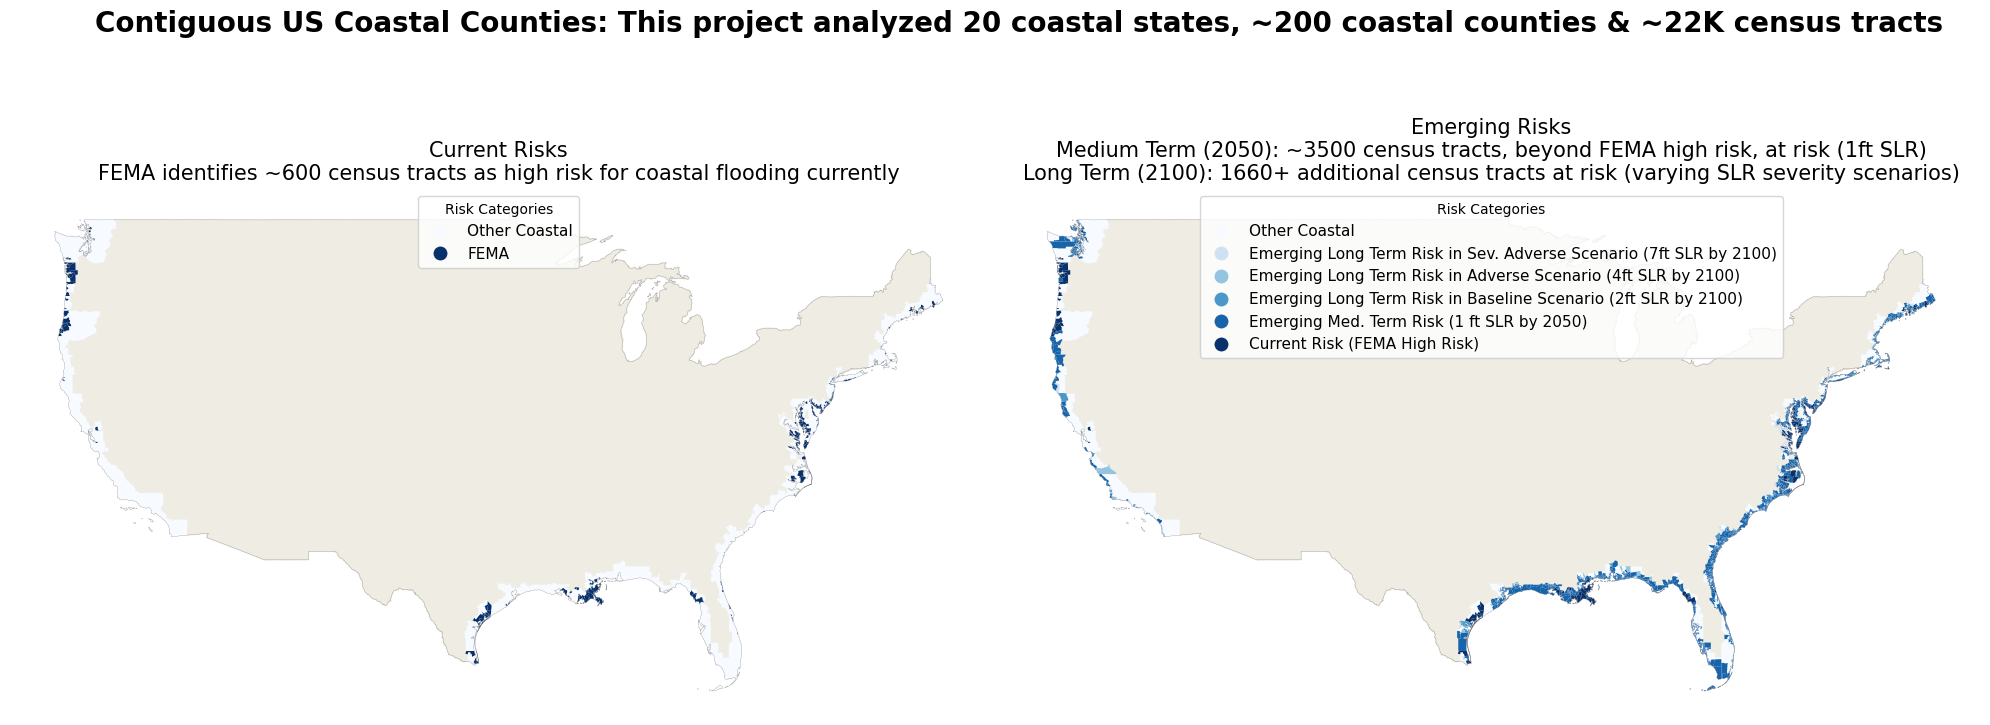

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,12));

gs_df_noncc.plot(ax = ax1, facecolor="#EEECE3", edgecolor="#EEECE3");
gs_df_cc.plot(ax = ax1, column = "fema_flag", categorical=True, cmap = "Blues", legend = True, 
              legend_kwds = {"loc": "upper center", "fontsize": 11, "title": "Risk Categories"});
us_borders_plotting.boundary.plot(ax = ax1, linewidth = 0.2, color = "grey") 
ax1.set_title("""Current Risks
FEMA identifies ~600 census tracts as high risk for coastal flooding currently""", fontsize = 15);
ax1.set_axis_off();


gs_df_noncc.plot(ax = ax2, facecolor="#EEECE3", edgecolor="#EEECE3");
gs_df_cc.plot(ax = ax2, column = "risk_category", categorical=True, cmap = "Blues", legend = True, 
              legend_kwds = {"loc": "upper center", "fontsize": 11, "title": "Risk Categories"});
us_borders_plotting.boundary.plot(ax = ax2, linewidth = 0.2, color = "grey")
ax2.set_title("""Emerging Risks
Medium Term (2050): ~3500 census tracts, beyond FEMA high risk, at risk (1ft SLR)
Long Term (2100): 1660+ additional census tracts at risk (varying SLR severity scenarios)""", fontsize = 15);
ax2.set_axis_off();


fig.text(0.05,.85, "Contiguous US Coastal Counties: This project analyzed 20 coastal states, ~200 coastal counties & ~22K census tracts", weight="bold", fontsize = 20);
plt.tight_layout();
plt.savefig("OutputData/Figures/US_current_vs_emerging_risks.png", bbox_inches = "tight");

In [22]:
_ = pd.DataFrame(gs_df_cc.risk_category.value_counts().sort_index(ascending = False))
_.columns = ["num_of_census_tracts_at_risk"]
_

num_of_census_tracts_at_risk
risk_category                                                                   
Current Risk (FEMA High Risk)                                                594
Emerging Med. Term Risk (1 ft SLR by 2050)                                  3523
Emerging Long Term Risk in Baseline Scenario (2...                           363
Emerging Long Term Risk in Adverse Scenario (4f...                           488
Emerging Long Term Risk in Sev. Adverse Scenari...                           812
Other Coastal                                                              16573

#### Output files

In [228]:
##overall aggregate file covering all states

op_file = gs_df_cc[['risk_category','state_name', 'county_name', 'census_tract_code']]
op_file.sort_values(["risk_category","state_name","county_name"], inplace = True, ascending = False)
op_file.to_csv("OutputData/Aggregate_SLR_impact.csv")
op_file[op_file.risk_category != "Other Coastal"].sample(3)

risk_category     state_name  \
52341         Emerging Med. Term Risk (1 ft SLR by 2050)       Delaware   
24410         Emerging Med. Term Risk (1 ft SLR by 2050)  Massachusetts   
44662  Emerging Long Term Risk in Sev. Adverse Scenar...       Virginia   

        county_name census_tract_code  
52341        Sussex       10005050706  
24410      Plymouth       25023530300  
44662  Hampton city       51650010702

In [229]:
##Aggregate and detailed SLR impact by state

def state_level_op(state):
    subset = op_file[(op_file.state_name == state) & 
            (op_file.risk_category != "Other Coastal")][["county_name", "census_tract_code", "risk_category"]]
    
    #aggreate impact for each scenario
    scenario_agg = pd.DataFrame(subset.groupby("risk_category").size().rename("census_tract_count"))
    scenario_agg["county_count"] = subset.groupby("risk_category")["county_name"].nunique()
    scenario_agg = scenario_agg.sort_index(ascending = False).iloc[:-1,:]

    _ = subset.groupby(["county_name","risk_category"], as_index = False).size()
    _ = _[_["size"]>0]

    #specific county level impact for each scenario
    scenario_county = (pd.pivot_table(data = _, index = "county_name", columns = "risk_category", 
                            values = "size", aggfunc="sum")).iloc[:,1:].sort_index(axis = 1, ascending = False)
    scenario_county.sort_values("Emerging Med. Term Risk (1 ft SLR by 2050)", ascending = False, inplace = True)

    with pd.ExcelWriter("OutputData/"+state+'.xlsx') as writer:  
        scenario_agg.to_excel(writer, sheet_name='scenario_impact_aggregate')
        scenario_county.to_excel(writer, sheet_name='scenario_impact_county')
    return scenario_agg, scenario_county

for state in op_file.state_name.unique():
    state_level_op(state)

In [224]:
print(f"Number of census tracts and counties expected to be impacted by SLR scenario for {op_file.state_name.unique()[-1]}")
scenario_agg

Number of census tracts and counties expected to be impacted by SLR scenario for Alabama


census_tract_count  \
risk_category                                                            
Current Risk (FEMA High Risk)                                        0   
Emerging Med. Term Risk (1 ft SLR by 2050)                          63   
Emerging Long Term Risk in Baseline Scenario (2...                   3   
Emerging Long Term Risk in Adverse Scenario (4f...                   3   
Emerging Long Term Risk in Sev. Adverse Scenari...                  10   

                                                    county_count  
risk_category                                                     
Current Risk (FEMA High Risk)                                  0  
Emerging Med. Term Risk (1 ft SLR by 2050)                     2  
Emerging Long Term Risk in Baseline Scenario (2...             1  
Emerging Long Term Risk in Adverse Scenario (4f...             2  
Emerging Long Term Risk in Sev. Adverse Scenari...             2

In [225]:
print(f"Number of census tracts expected to be impacted by county and by SLR scenario for {op_file.state_name.unique()[-1]}") #sample state
scenario_county

Number of census tracts expected to be impacted by county and by SLR scenario for Alabama


risk_category  Current Risk (FEMA High Risk)  \
county_name                                    
Mobile                                     0   
Baldwin                                    0   

risk_category  Emerging Med. Term Risk (1 ft SLR by 2050)  \
county_name                                                 
Mobile                                                 33   
Baldwin                                                30   

risk_category  Emerging Long Term Risk in Baseline Scenario (2ft SLR by 2100)  \
county_name                                                                     
Mobile                                                         3                
Baldwin                                                        0                

risk_category  Emerging Long Term Risk in Adverse Scenario (4ft SLR by 2100)  \
county_name                                                                    
Mobile                                                         2               
Baldwin                                                        1               

risk_category  Emerging Long Term Risk in Sev. Adverse Scenario (7ft SLR by 2100)  
county_name                                                                        
Mobile                                                         9                   
Baldwin                                                        1

<b>State and Region Level Plots</b>

In [122]:
def plot_coastal_counties(gs_df_noncc, gs_df_cc, county_borders_plotting, identifier, 
                          plot_non_coastal_zones = "Y", state = "Y"):
    
    """Plot geospatial maps showing US coastal zones, FEMA high risk zones and SLR zones for each state
    I/P: relevant geo dBs, figure formatting attributes (legend location, whether non coastal regions need to be shown)
    indicator of the level of granularity of the plot (default is contiguous US) and names of the state/county to plot,
    identifier indicating states or counties to include
    O/P: plot"""
    
    fig, ax = plt.subplots(figsize = (8,8))
    if type(identifier) == str: identifier = [identifier] 
    
    #creating the relevant subset dataframes
    if state == "Y":
        gs_df_noncc = gs_df_noncc[gs_df_noncc.state_name.isin(identifier)]
        gs_df_cc = gs_df_cc[gs_df_cc.state_name.isin(identifier)]
        county_borders_plotting = county_borders_plotting[county_borders_plotting.state_name.isin(identifier)]
    else:
#         gs_df_noncc = gs_df_noncc[gs_df_noncc.region.isin(identifier)]
        gs_df_cc = gs_df_cc[gs_df_cc.region.isin(identifier)]
        
    #plot format settings
    font_size, title_size  = 7, 10
    chart_title = f"Coastal counties in {' '.join(identifier)}"
    if (identifier[0] in ["Texas", "Georgia", "SouthEast", "WesternGulf"]) or (identifier == ['New Jersey','New York','Connecticut']):
        legend_loc = "lower right"
    elif identifier[0] in ["Florida", "Louisiana", "EastGulf"]:
        legend_loc = "center left"
    elif identifier[0] in ["Washington", "North Carolina", "New Jersey", "Maine"]:
        legend_loc = "upper left"
    elif identifier[0] in ["Oregon","Massachusetts", "Delaware"]:
        legend_loc = "upper right"
    else:
        legend_loc = "best"

    #plots
    if plot_non_coastal_zones == "Y":
        gs_df_noncc.plot(ax = ax, facecolor="#EEECE3", edgecolor="#EEECE3")
        
    gs_df_cc.plot(ax=ax, column="risk_category", cmap="GnBu", categorical=True, alpha = 0.7, legend = True, legend_kwds = {"loc": legend_loc, "fontsize": font_size})
    gs_df_cc.boundary.plot(ax= ax, linewidth = 0.2, color = "grey")

    if state == "Y": #add county name to plot
        county_borders_plotting.boundary.plot(ax= ax, linewidth = 0.2, color = "grey");
        county_borders_plotting.apply(lambda x: ax.annotate(text=x['county_name'], xy=x.geometry.centroid.coords[0], ha='center', size = 7), axis=1);

    #title details
    _ = gs_df_cc.risk_category.value_counts().sort_index()

    if _.iloc[-1] == 0:  #no current fema zone
        ax.set_title(f"""{chart_title}
Over the medium term (2050), {_["Emerging Med. Term Risk (1 ft SLR by 2050)"]} addtional census tracts will be at risk for SLR of 1ft.
Over the longer term (2100), {_.iloc[1:4].sum()} additional census tracts may be at risk depending on the specific SLR scenario""",
                 fontsize = title_size)
        
    elif _.iloc[-2] == 0:  #no medium term SLR zones
        ax.set_title(f"""{chart_title}
    {_["Current Risk (FEMA High Risk)"]} census tracts are currently known to be at risk for flooding (FEMA) 
Over the longer term (2100), {_.iloc[1:4].sum()} additional census tracts may be at risk depending on the specific SLR scenario""",
                 fontsize = title_size)

    else:
        ax.set_title(f"""{chart_title}
    {_["Current Risk (FEMA High Risk)"]} census tracts are currently known to be at risk for flooding (FEMA) 
Over the medium term (2050), {_["Emerging Med. Term Risk (1 ft SLR by 2050)"]} additional census tracts will be at risk for SLR of 1ft
Over the longer term (2100), {_.iloc[1:4].sum()} additional census tracts may be at risk depending on the specific SLR scenario""",
                 fontsize = title_size)
    
    ax.set_axis_off();
    plt.tight_layout();
    
    imgname = chart_title.replace(" ","_")
    plt.savefig("OutputData/Figures/"+ imgname +".png", bbox_inches = "tight")

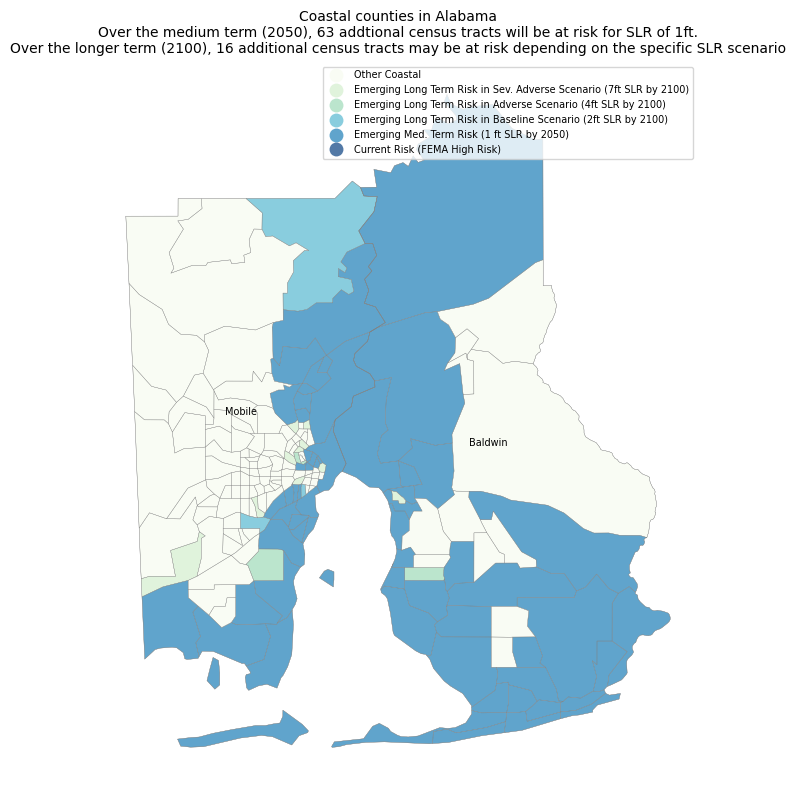

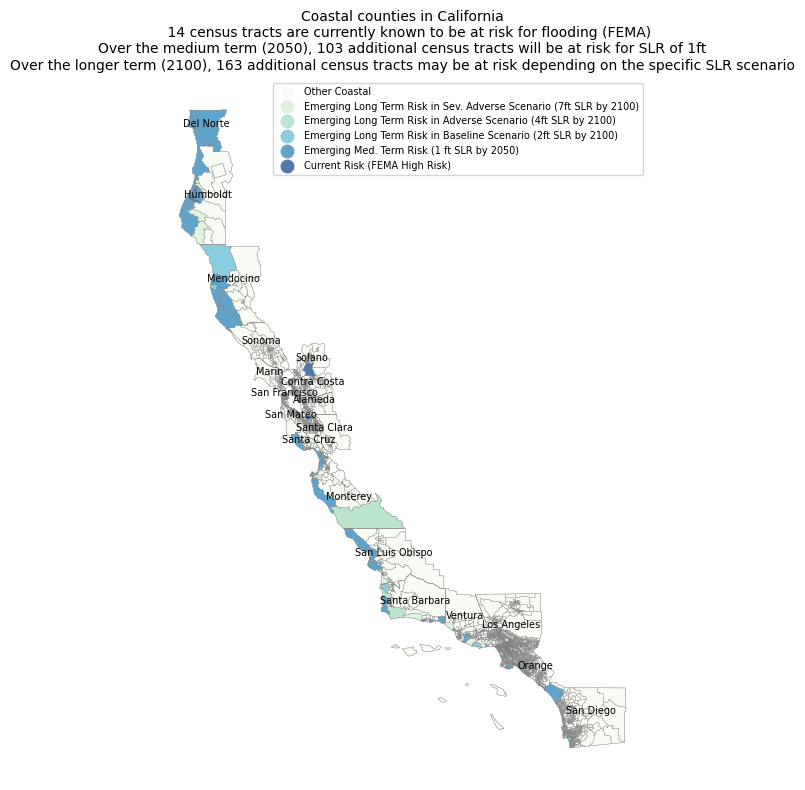

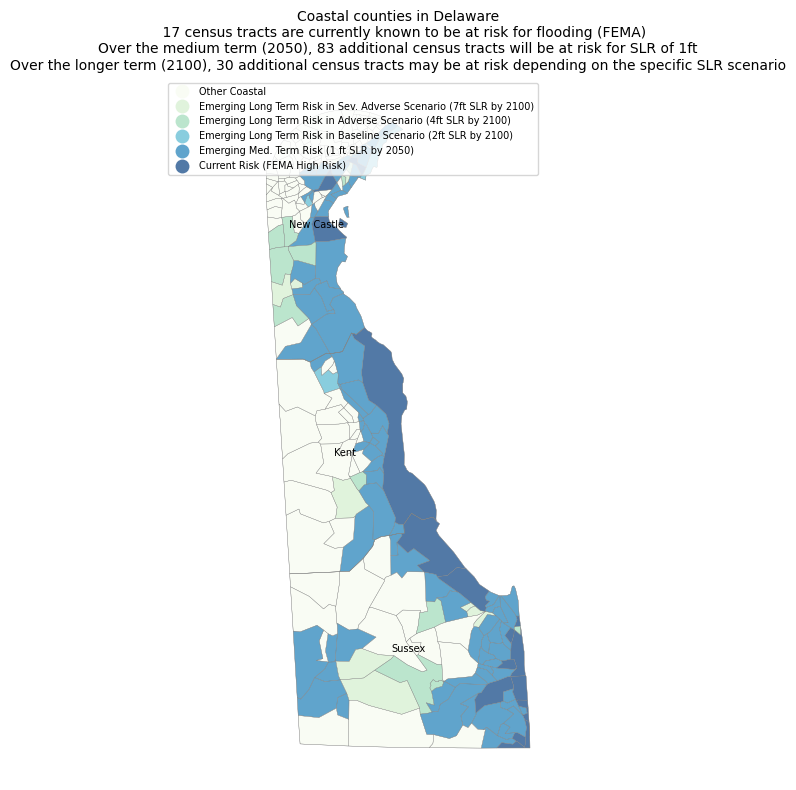

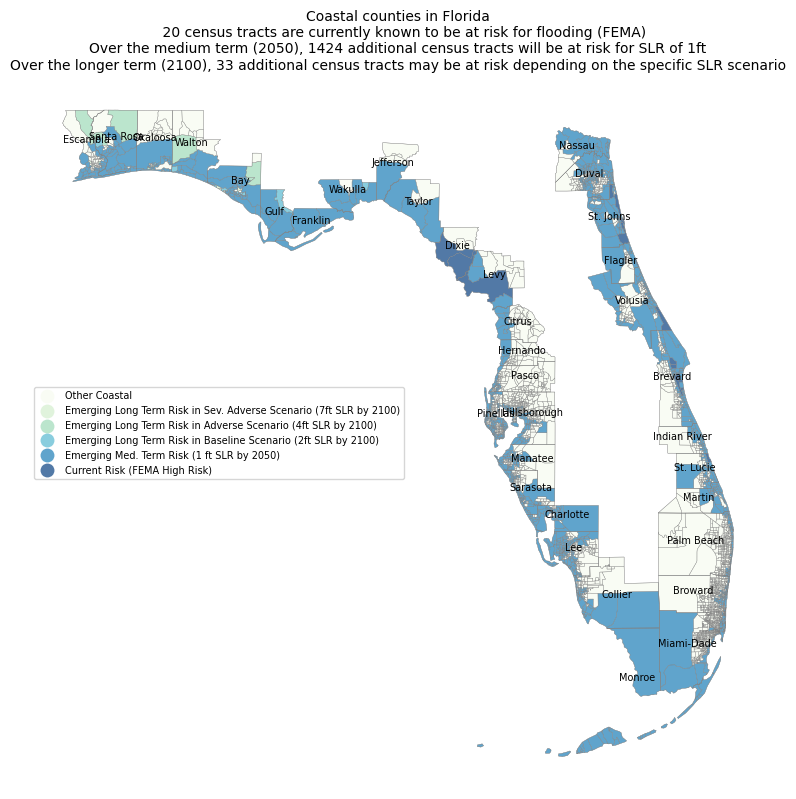

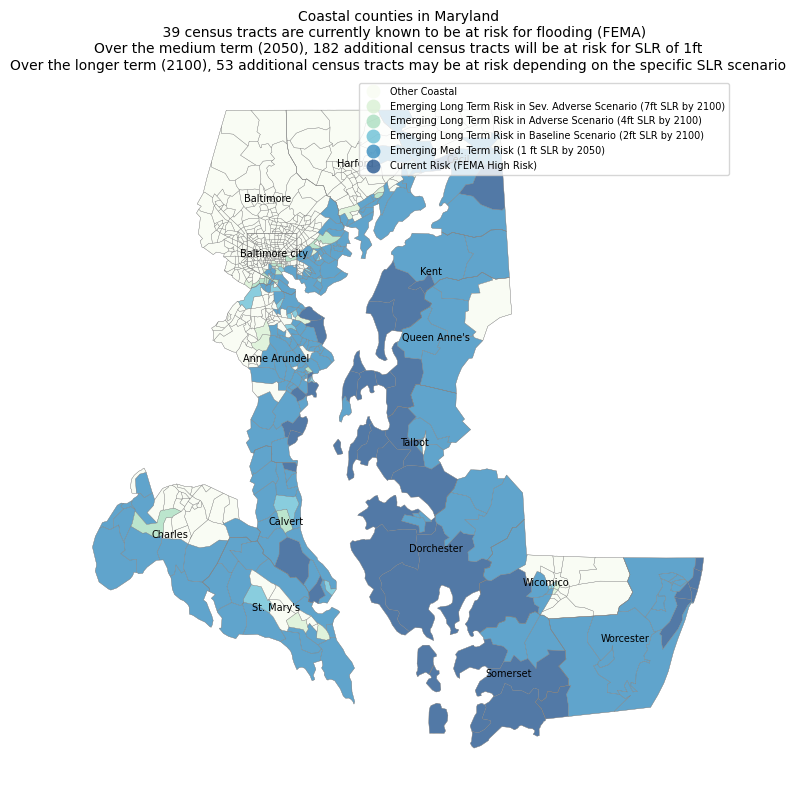

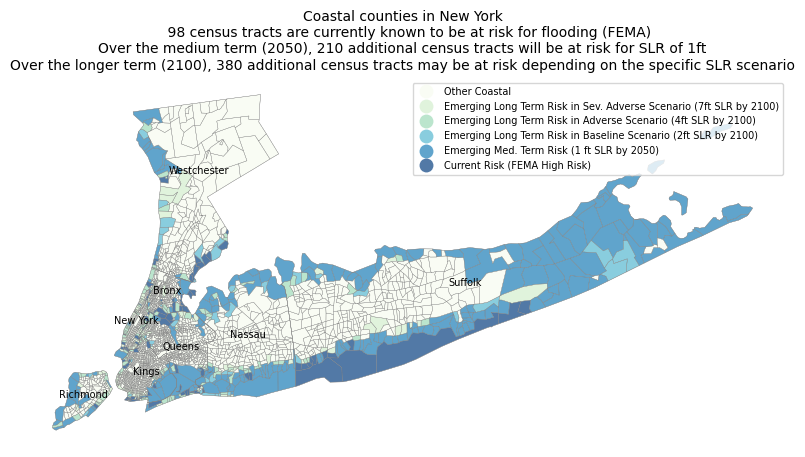

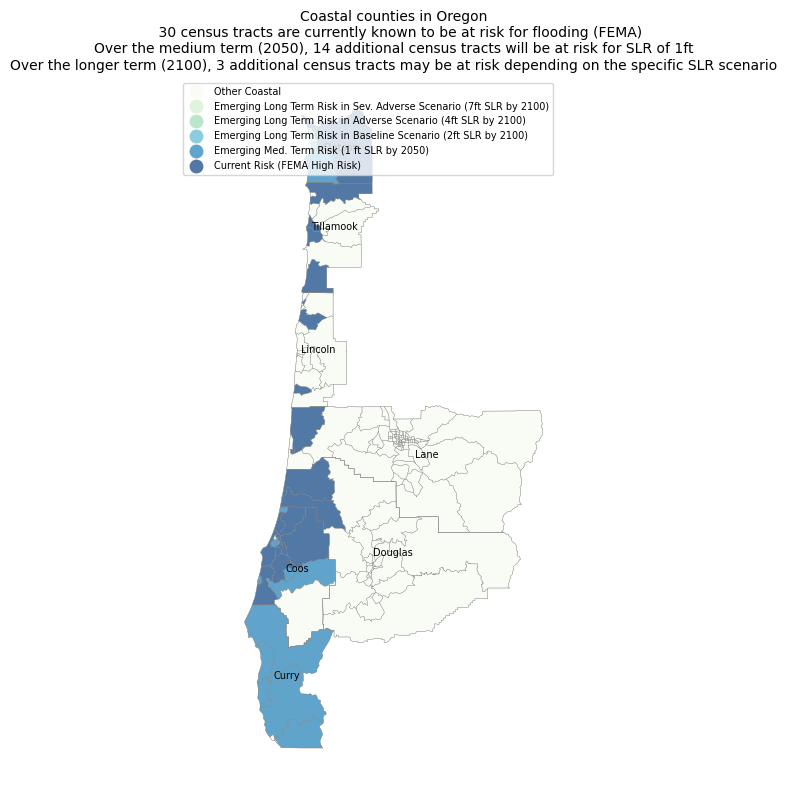

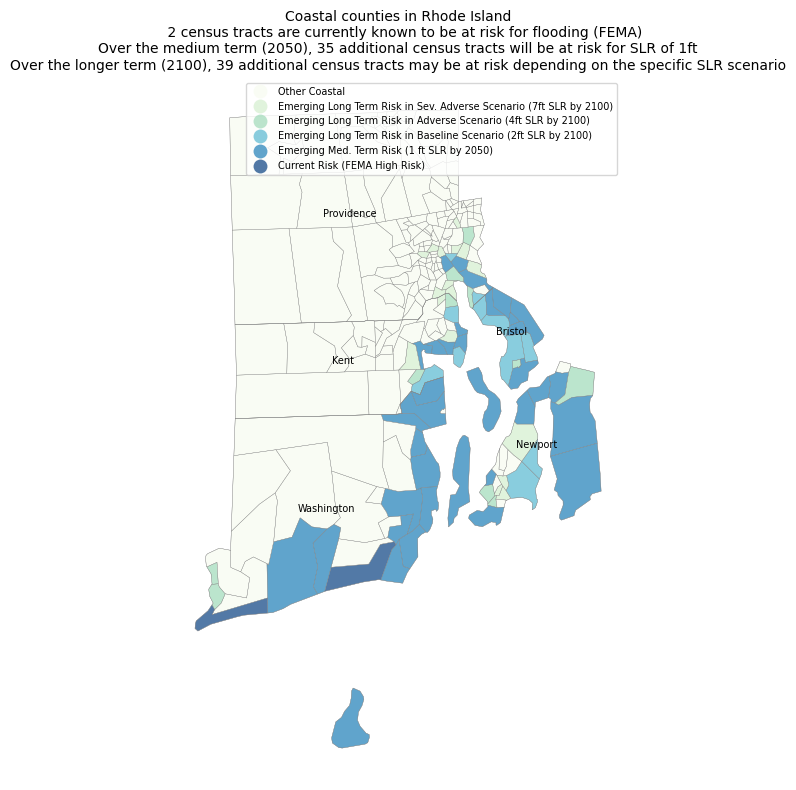

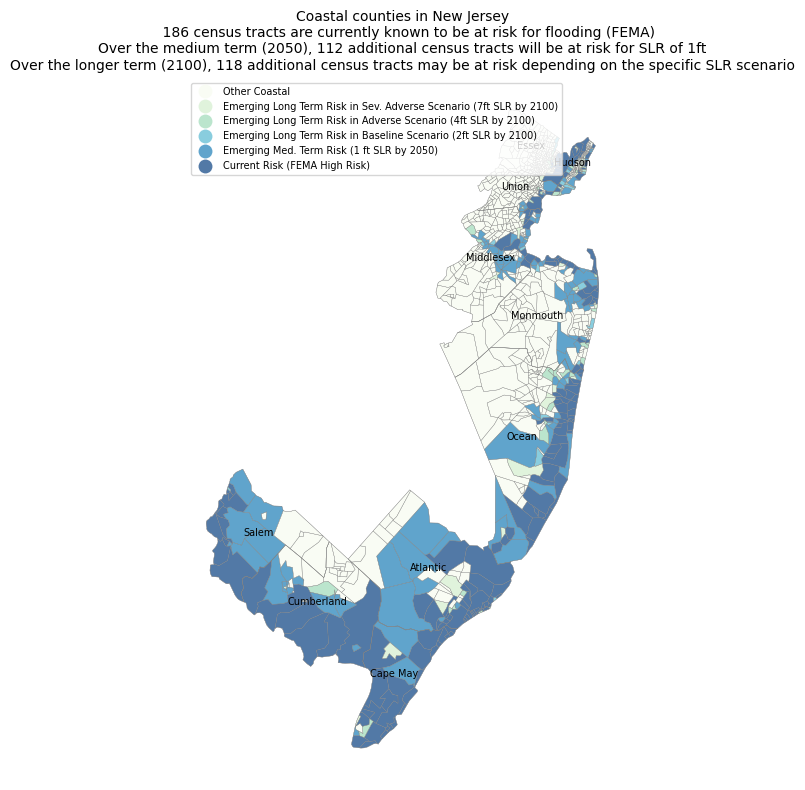

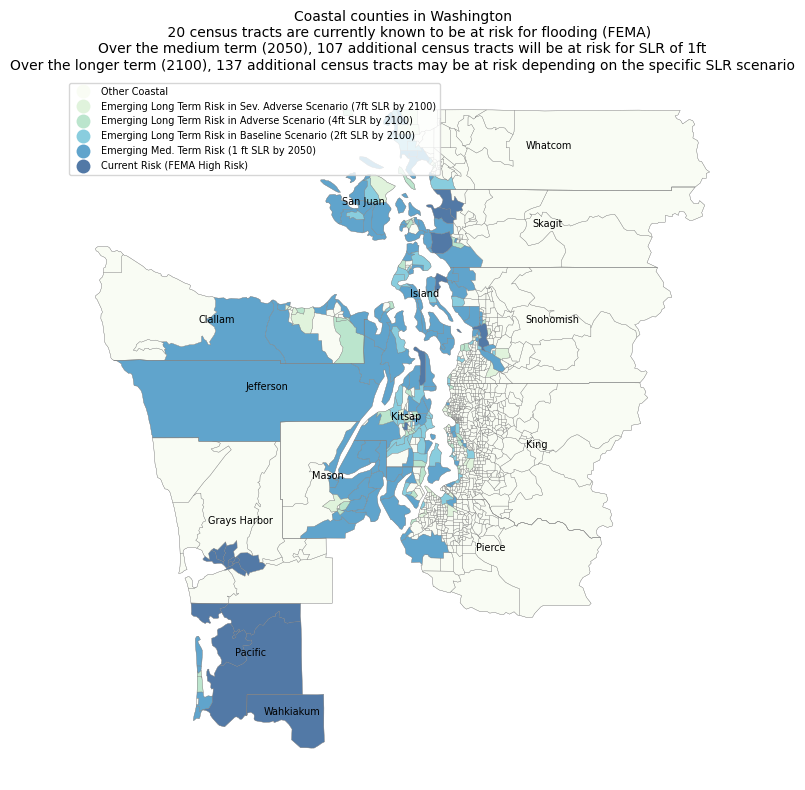

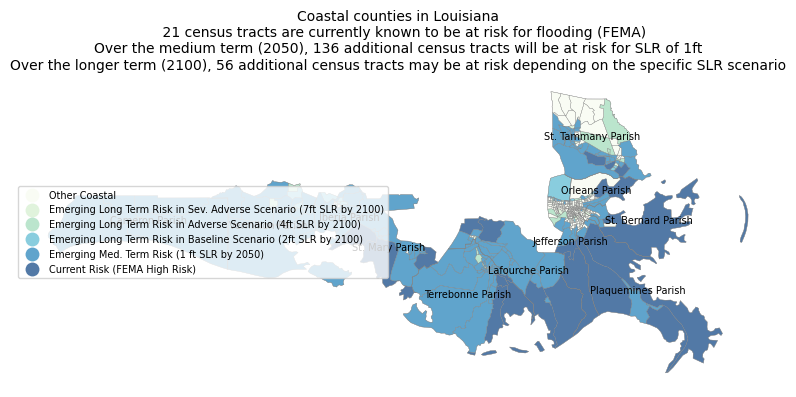

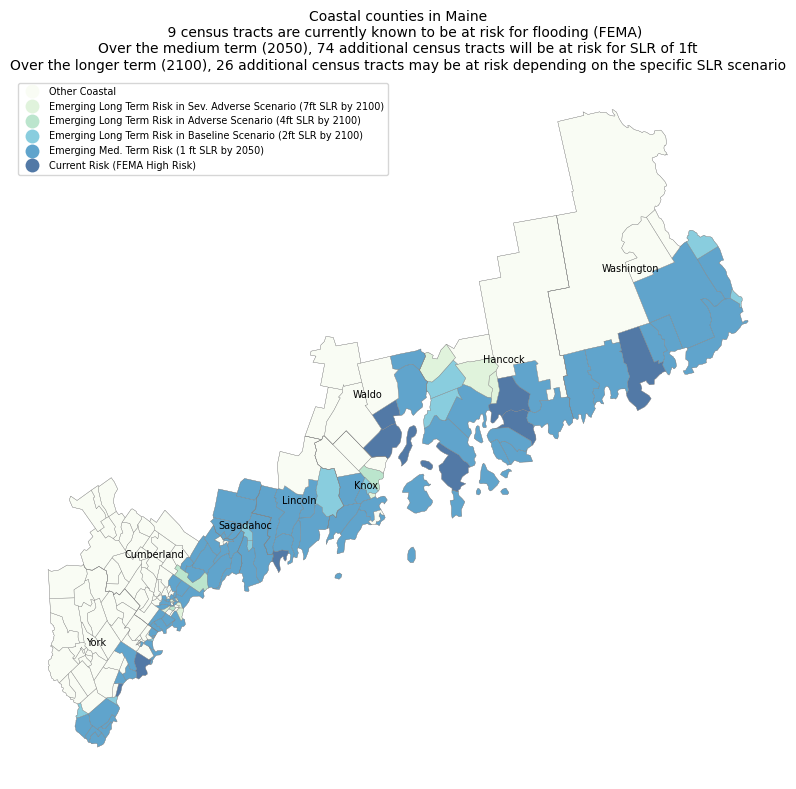

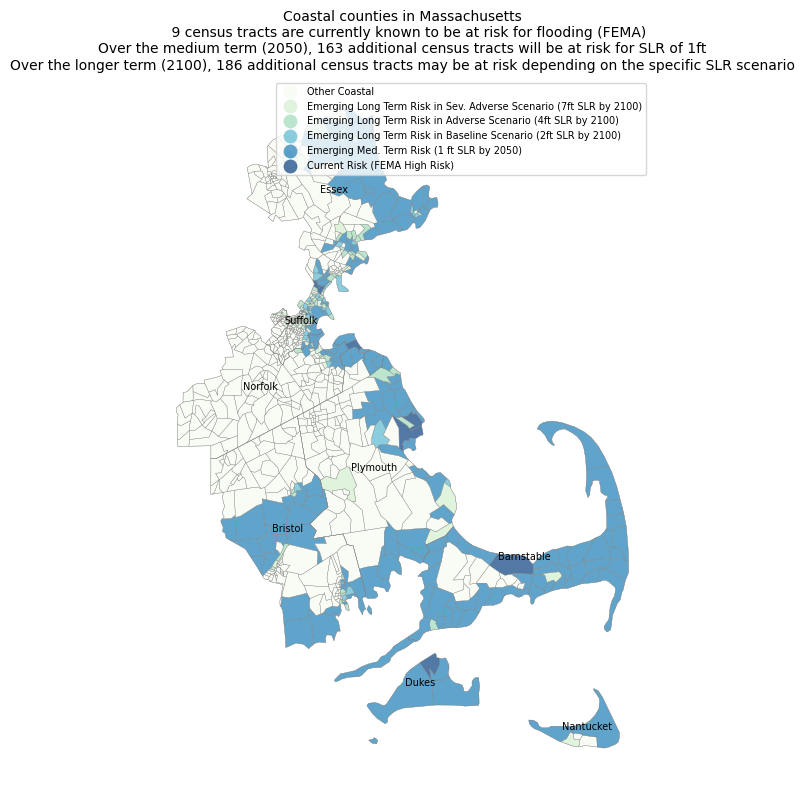

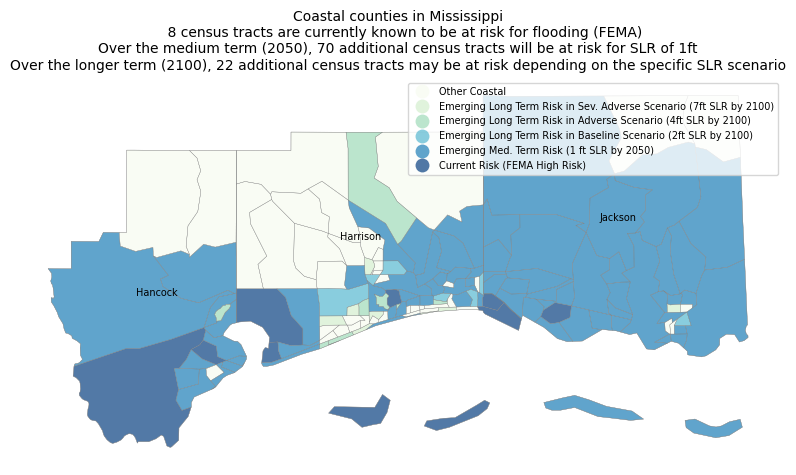

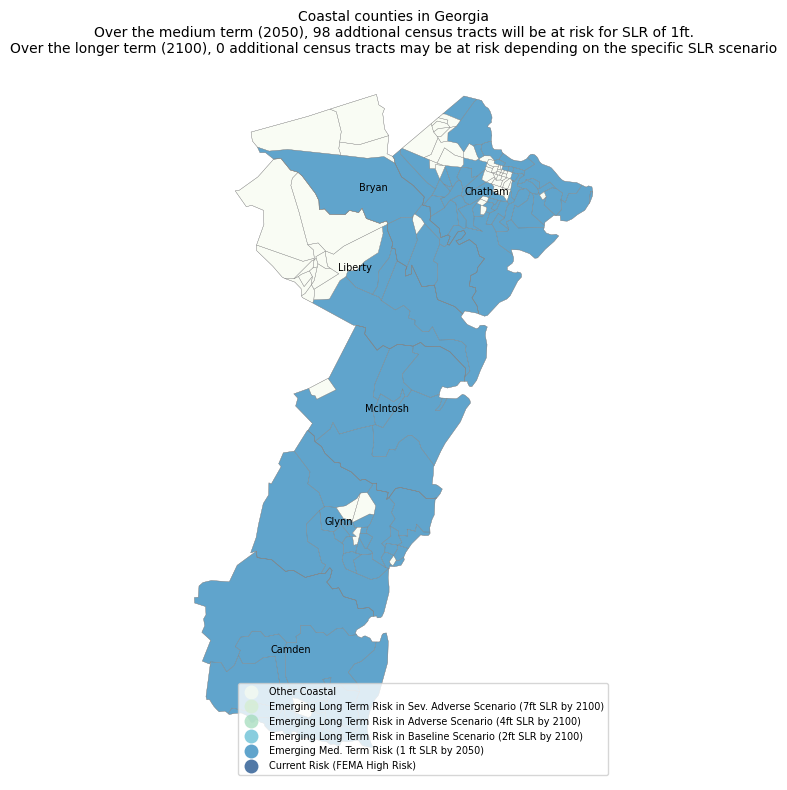

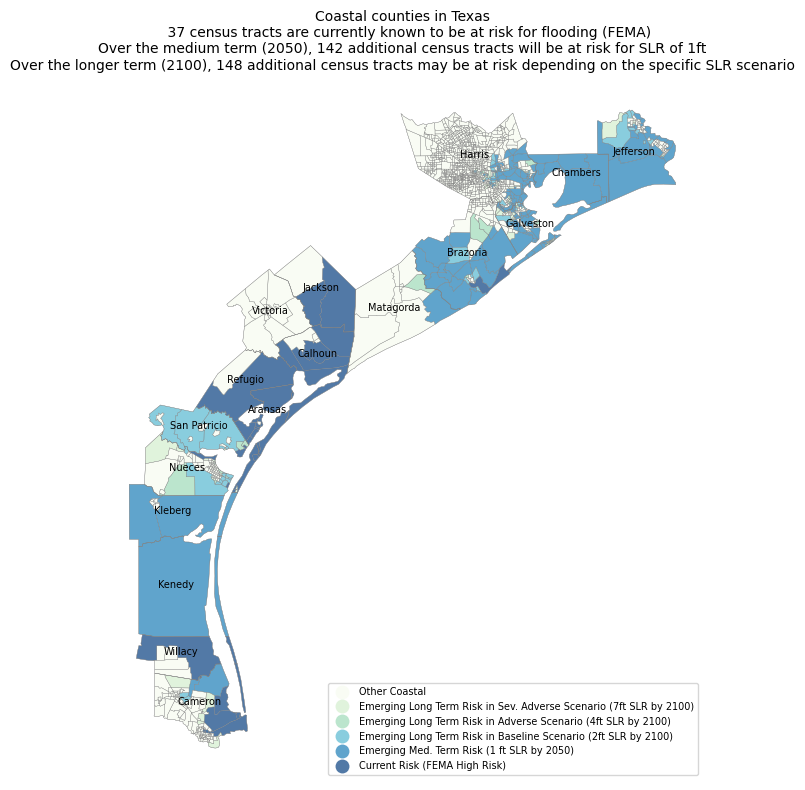

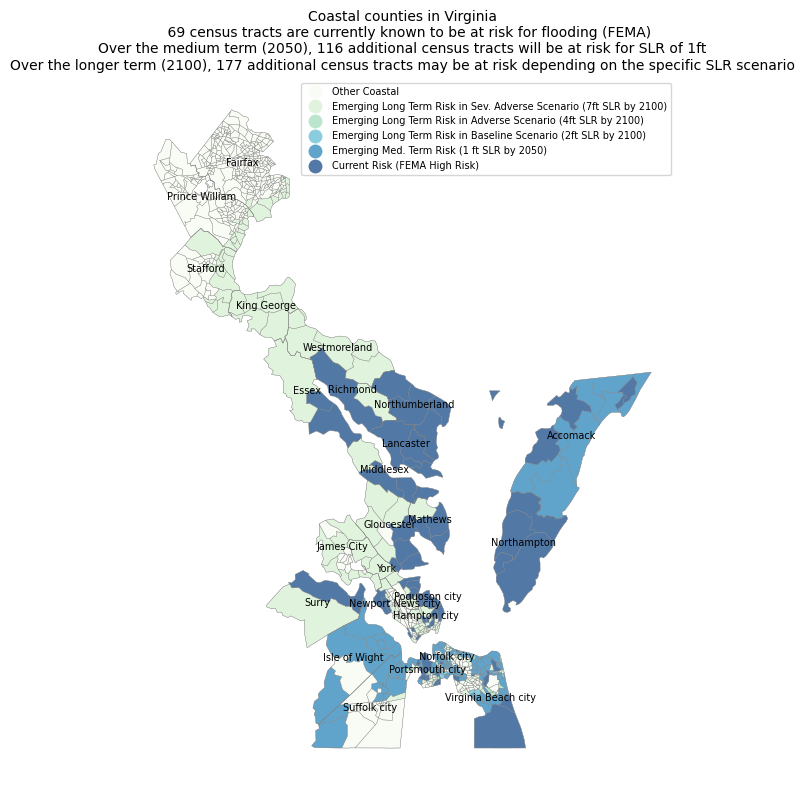

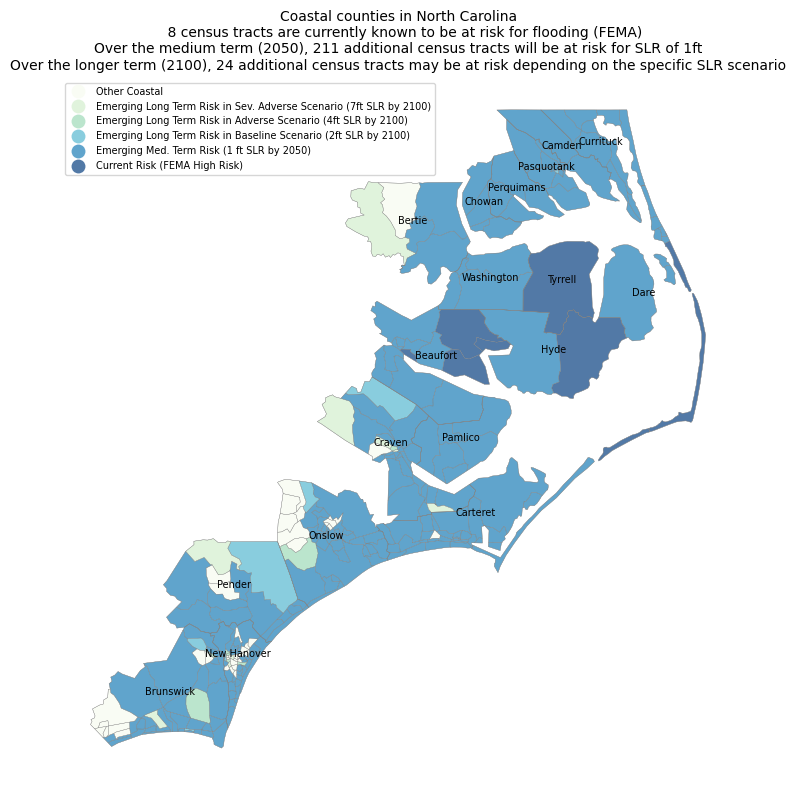

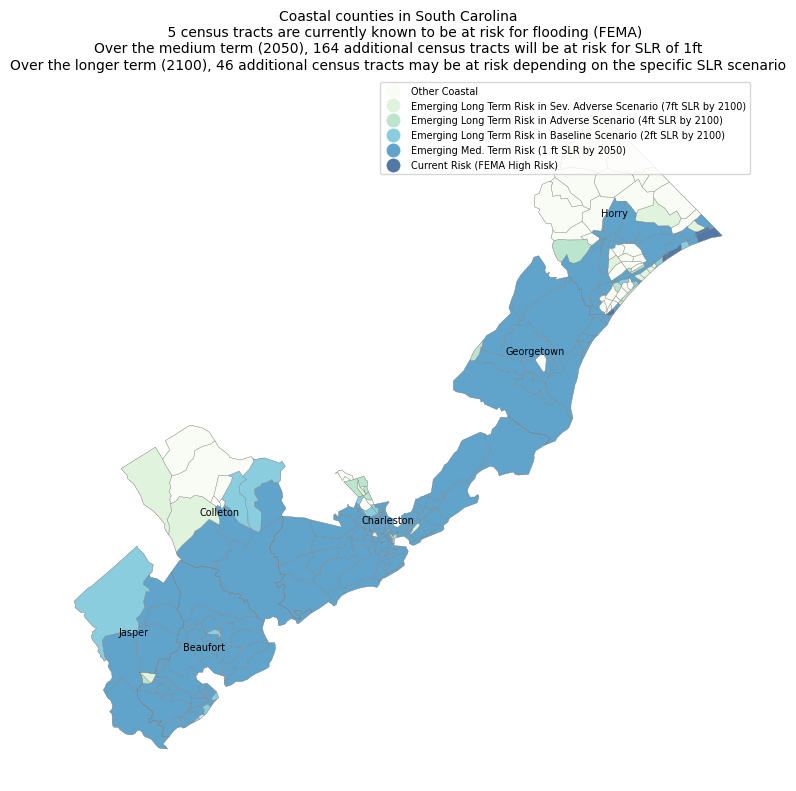

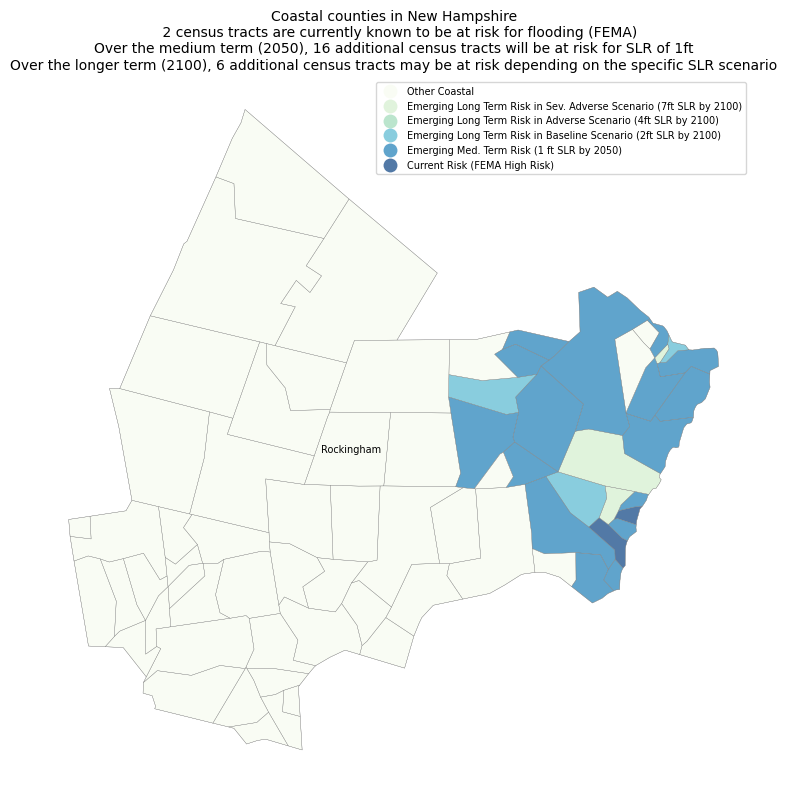

In [124]:
#state-level
for state in gs_df_cc.state_name.unique():
    plot_coastal_counties(gs_df_noncc, gs_df_cc, county_borders_plotting, state, "N", "Y")

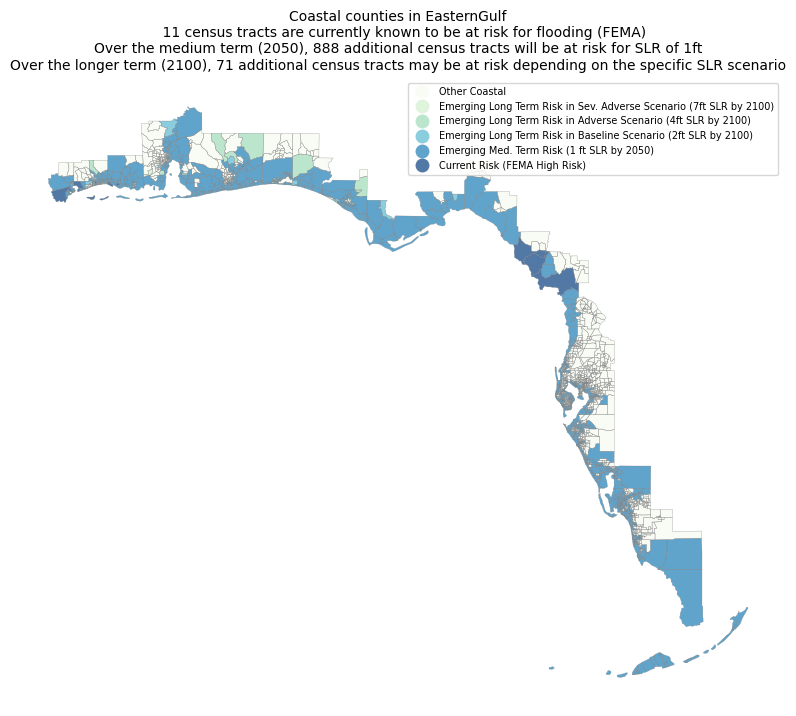

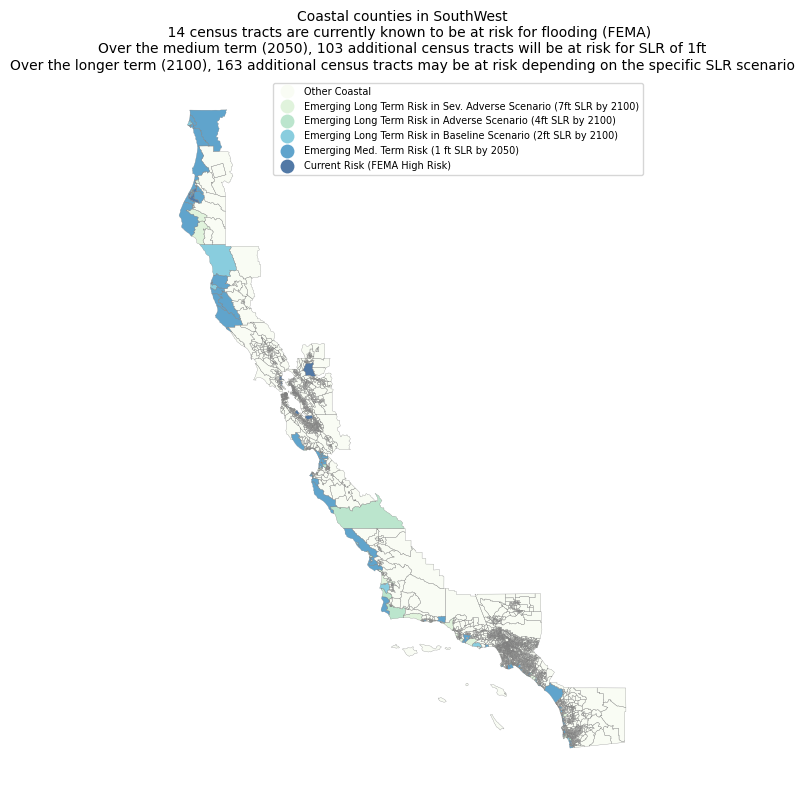

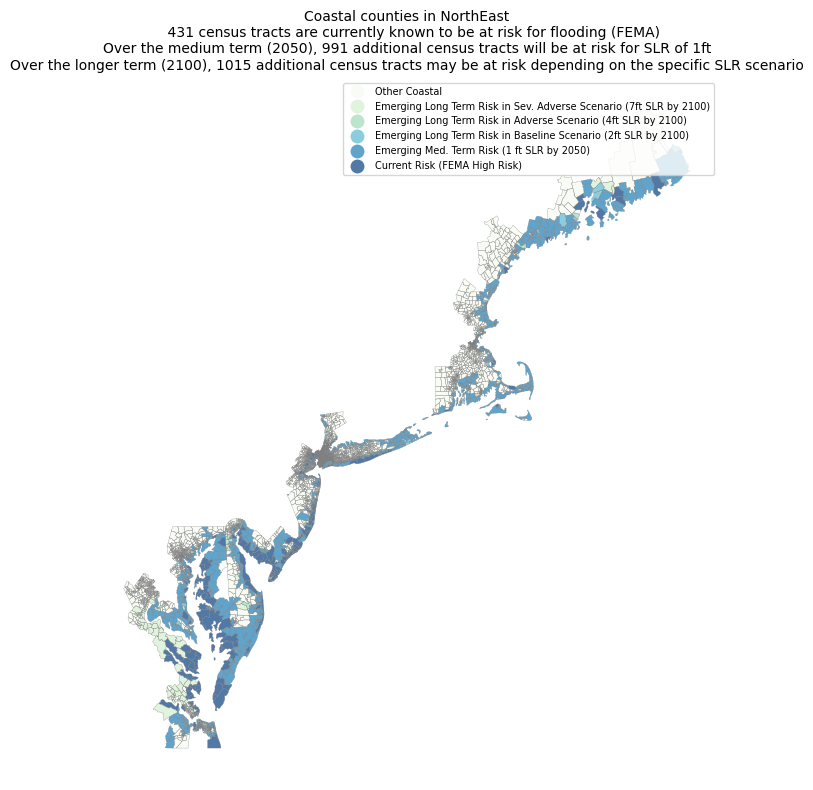

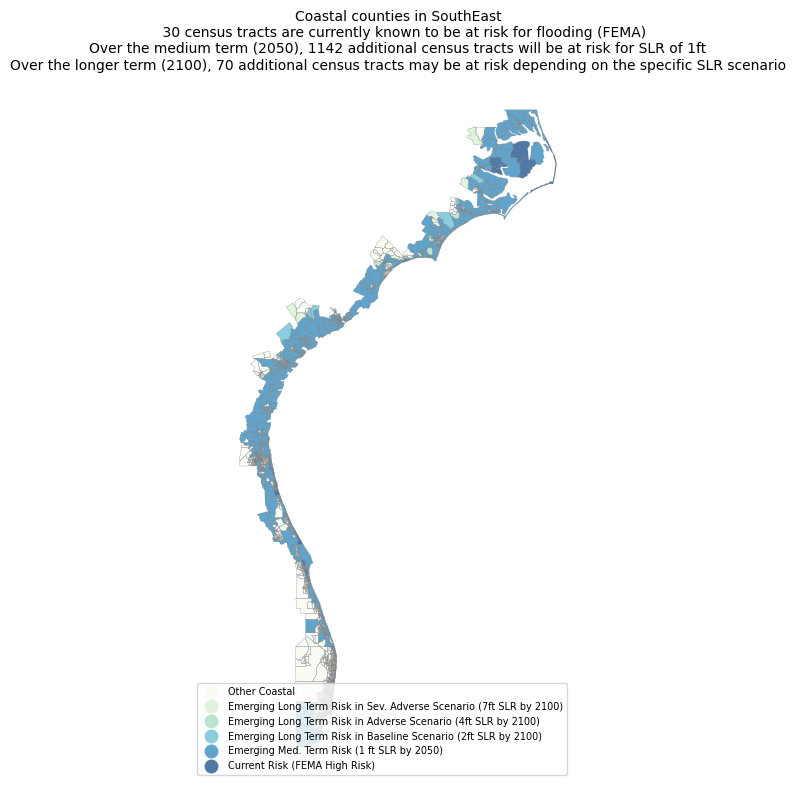

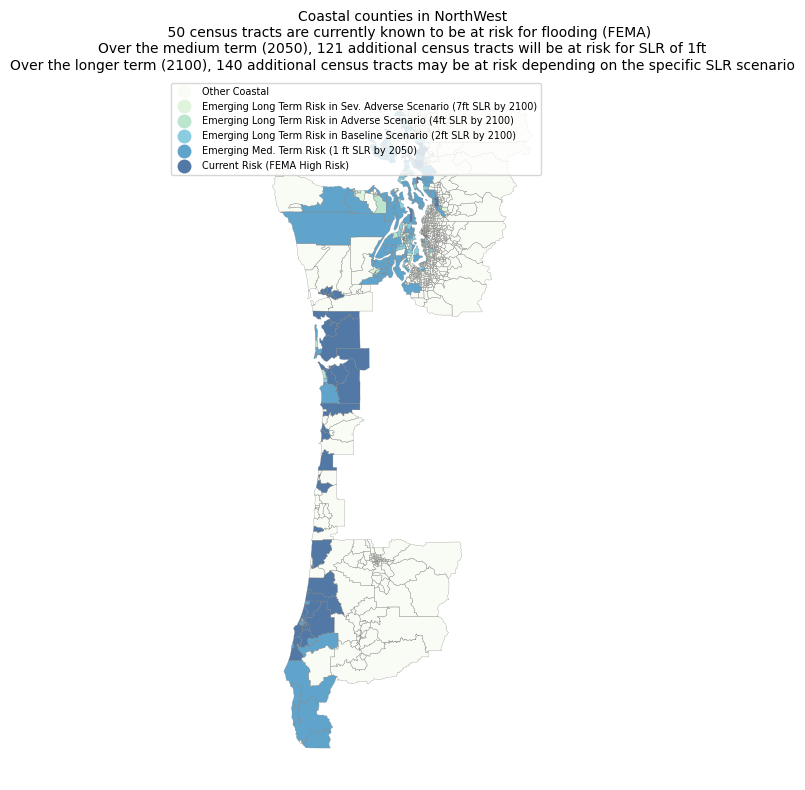

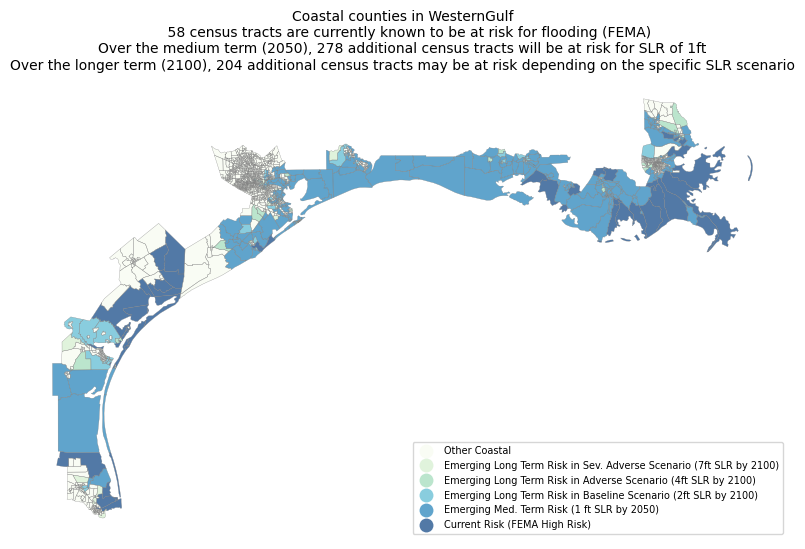

In [125]:
#region-level
for region in gs_df_cc.region.unique():
    plot_coastal_counties(gs_df_noncc, gs_df_cc, county_borders_plotting, region, "N", "N")

In [ ]:
# plot_coastal_counties(gs_df_noncc, gs_df_cc, county_borders_plotting, "New York", "N", "Y")
# plot_coastal_counties(gs_df_noncc, gs_df_cc, county_borders_plotting, "New Jersey", "N", "Y")
# plot_coastal_counties(gs_df_noncc, gs_df_cc, county_borders_plotting, ['New Jersey','New York','Connecticut'], "N", "Y")

###
#### Case Study - Current vs Emerging SLR Risks in Florida

In [231]:
FL_scenario_agg, FL_scenario_county = state_level_op("Florida")

In [232]:
FL_scenario_agg

census_tract_count  \
risk_category                                                            
Current Risk (FEMA High Risk)                                       20   
Emerging Med. Term Risk (1 ft SLR by 2050)                        1424   
Emerging Long Term Risk in Baseline Scenario (2...                  15   
Emerging Long Term Risk in Adverse Scenario (4f...                  10   
Emerging Long Term Risk in Sev. Adverse Scenari...                   8   

                                                    county_count  
risk_category                                                     
Current Risk (FEMA High Risk)                                  7  
Emerging Med. Term Risk (1 ft SLR by 2050)                    34  
Emerging Long Term Risk in Baseline Scenario (2...             6  
Emerging Long Term Risk in Adverse Scenario (4f...             5  
Emerging Long Term Risk in Sev. Adverse Scenari...             3

In [238]:
FL_scenario_county[FL_scenario_county.iloc[:,0]>0].sort_values("Current Risk (FEMA High Risk)", ascending = False)

risk_category  Current Risk (FEMA High Risk)  \
county_name                                    
St. Johns                                  7   
Brevard                                    6   
Volusia                                    2   
Dixie                                      2   
St. Lucie                                  1   
Flagler                                    1   
Levy                                       1   

risk_category  Emerging Med. Term Risk (1 ft SLR by 2050)  \
county_name                                                 
St. Johns                                              34   
Brevard                                                62   
Volusia                                                62   
Dixie                                                   0   
St. Lucie                                              28   
Flagler                                                10   
Levy                                                    3   

risk_category  Emerging Long Term Risk in Baseline Scenario (2ft SLR by 2100)  \
county_name                                                                     
St. Johns                                                      0                
Brevard                                                        0                
Volusia                                                        0                
Dixie                                                          0                
St. Lucie                                                      0                
Flagler                                                        0                
Levy                                                           0                

risk_category  Emerging Long Term Risk in Adverse Scenario (4ft SLR by 2100)  \
county_name                                                                    
St. Johns                                                      0               
Brevard                                                        0               
Volusia                                                        0               
Dixie                                                          0               
St. Lucie                                                      0               
Flagler                                                        0               
Levy                                                           0               

risk_category  Emerging Long Term Risk in Sev. Adverse Scenario (7ft SLR by 2100)  
county_name                                                                        
St. Johns                                                      0                   
Brevard                                                        0                   
Volusia                                                        0                   
Dixie                                                          0                   
St. Lucie                                                      0                   
Flagler                                                        0                   
Levy                                                           0

In [243]:
#top 10 counties expected to experience significant medium term SLR impact based on number of census tracts expected to be impacted
FL_scenario_county.iloc[:10,:2].sort_index(axis= 1)

risk_category  Emerging Med. Term Risk (1 ft SLR by 2050)  \
county_name                                                 
Pinellas                                              140   
Duval                                                 120   
Lee                                                   118   
Miami-Dade                                            114   
Broward                                                91   
Hillsborough                                           90   
Palm Beach                                             76   
Sarasota                                               71   
Volusia                                                62   
Brevard                                                62   

risk_category  Current Risk (FEMA High Risk)  
county_name                                   
Pinellas                                   0  
Duval                                      0  
Lee                                        0  
Miami-Dade                                 0  
Broward                                    0  
Hillsborough                               0  
Palm Beach                                 0  
Sarasota                                   0  
Volusia                                    2  
Brevard                                    6

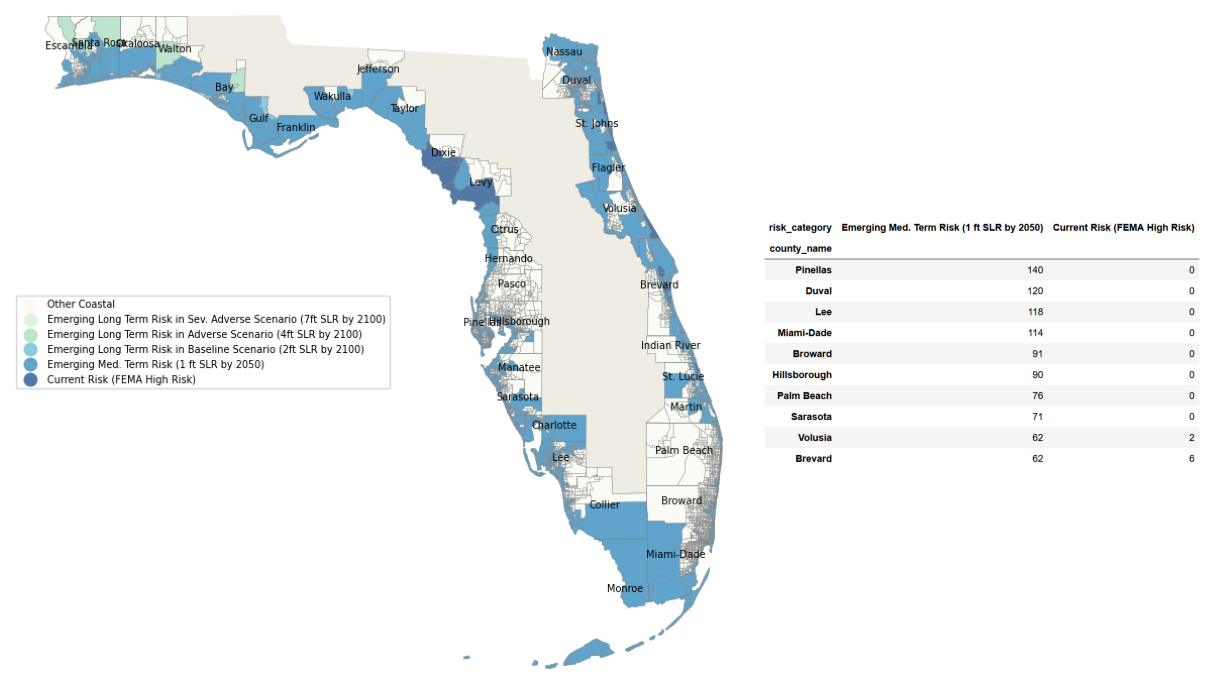

In [281]:
image1 = plt.imread("OutputData/Figures/FL_edit.png")
image2 = plt.imread("OutputData/Figures/FL_scenario_county_top10.png")

f, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [3.5, 1.2]}, figsize =(15,7));
ax1.set_axis_off();
ax1.imshow(image1);
ax2.set_axis_off();
ax2.imshow(image2); 

# plt.suptitle("Florida Coastal Counties Emerging SLR risks", fontsize = 12);
plt.savefig("OutputData/Figures/FL_current_vs_emerging_risks2.png", bbox_inches = "tight");